# Logistic Regression vs LOOT

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd.functional import hessian
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Set up before training

In [ ]:
#transforms_MNIST = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = (0.1307,), std = (0.3081,))])

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download = True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download = True)

In [ ]:
input_size = 784
num_classes = 10
num_epochs = 20 # can change
batch_size = 100 # can change
learning_rate = 0.001 # can change

training_size = 6000 # use a smaller dataset for faster computation
testing_size = 1000

#training_selector = np.random.choice(range(60000), replace = False, size = training_size)
#testing_selector = np.random.choice(range(10000), replace = False, size = testing_size)
training_selector = np.arange(training_size)
testing_selector = np.arange(testing_size)

class Alpha_Train_Dataset(Dataset):
  def __init__(self):
      
      self.x = train_dataset.data[training_selector].float()
      self.y = train_dataset.targets[training_selector]
      
      #self.n_samples = int(train_dataset.data.shape[0]*alpha)
      self.n_samples = len(training_selector)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

class Alpha_Test_Dataset(Dataset):
  def __init__(self):
      
      self.x = test_dataset.data[testing_selector].float()#[random_selector].float()
      self.y = test_dataset.targets[testing_selector]#[random_selector]
      
      self.n_samples = len(testing_selector)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

class NeuralNet(nn.Module):
  def __init__(self, input_size, num_classes):
    super(NeuralNet, self).__init__()
    self.l1 = nn.Linear(input_size, num_classes, bias = False)
  
  def forward(self, x):
    out = self.l1(x)
    return out

## Training

In [ ]:
alpha_train_dataset = Alpha_Train_Dataset()
train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=batch_size, shuffle=True)

model = NeuralNet(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # randn term doesn't matter, can delete
        images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081 + torch.randn(batch_size, 784)/100).to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # add l2 regularization
        l2_lambda = 0.005
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
 
        loss = loss + l2_lambda * l2_norm

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

alpha_test_dataset = Alpha_Test_Dataset()
test_loader = torch.utils.data.DataLoader(dataset=alpha_test_dataset, batch_size=1, shuffle=False)

misclassified_lst = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    counter = 0
    for images, labels in test_loader:
        images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)
        labels = labels.to(device)
        output = model(images)
        # value, index
        _, predictions = torch.max(output, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()

        if (predictions == labels).sum().item() == 0:
            misclassified_lst.append(counter)
        counter += 1

    acc = 100 * n_correct/n_samples

In [ ]:
acc

89.4

## Calculate Inverse Hessian

In [ ]:
with torch.no_grad():
    w = torch.cat(tuple([_.view(-1) for _ in model.parameters()])).detach()

In [ ]:
def logistics_regression_loss_all(w):
    
    #w = w.clone().detach().requires_grad_(True)

    train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=training_size, shuffle=False)
    examples = iter(train_loader)
    images, labels = examples.next()

    images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)

    out1 = F.linear(images, w.reshape(10,784))

    loss = criterion(out1, labels.to(device))

    l2_lambda = 0.005
    l2_norm = sum(w.pow(2.0))
 
    loss = loss + l2_lambda * l2_norm

    loss = loss*training_size


    return loss

In [ ]:
with torch.no_grad():
   Hessian = hessian(logistics_regression_loss_all, w)/training_size

In [ ]:
inv_hessian = torch.linalg.inv(Hessian)

In [ ]:
inv_hessian

tensor([[ 9.9770e+01, -2.2967e-01, -2.2967e-01,  ...,  2.4694e-02,
          2.4694e-02,  2.4694e-02],
        [-2.2969e-01,  9.9770e+01, -2.2969e-01,  ...,  2.4698e-02,
          2.4698e-02,  2.4699e-02],
        [-2.2967e-01, -2.2967e-01,  9.9770e+01,  ...,  2.4695e-02,
          2.4695e-02,  2.4695e-02],
        ...,
        [ 2.4696e-02,  2.4696e-02,  2.4696e-02,  ...,  9.9761e+01,
         -2.3890e-01, -2.3890e-01],
        [ 2.4696e-02,  2.4696e-02,  2.4696e-02,  ..., -2.3890e-01,
          9.9761e+01, -2.3890e-01],
        [ 2.4696e-02,  2.4696e-02,  2.4696e-02,  ..., -2.3890e-01,
         -2.3890e-01,  9.9761e+01]], device='cuda:0')

In [ ]:
# check how many negative eigenvalues, should be zero
L, Q = torch.linalg.eigh(Hessian)

In [ ]:
(L < 0).sum()

tensor(0, device='cuda:0')

## Calculate gradient at single point

In [ ]:
def loss_grad_at_point(w, train_point):
    # w should be torch.cat(tuple([_.view(-1) for _ in model.parameters()]))
    # train_point should be alpha_train_dataset[0], a tuple of image and label

    w = w.clone().detach().requires_grad_(True)

    images = ((train_point[0].reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)

    out1 = F.linear(images, w.reshape(10,784))

    loss = criterion(out1, torch.tensor([train_point[1]]).to(device))

    l2_lambda = 0.005
    l2_norm = sum(w.pow(2.0))
 
    loss = loss + l2_lambda * l2_norm

    loss.backward()

    return w.grad

## Define a test point

In [ ]:
misclassified_lst[5]

80

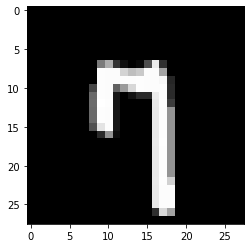

In [ ]:
test_point = (test_dataset.data[80].float(), test_dataset.targets[80])
plt.imshow(alpha_test_dataset[80][0], cmap = "gray")

## Calculate IF scores

In [ ]:
def calculate_if(train_point, test_point, inv_Hessian):
    # test point should be alpha_test_dataset[10]

    test_loss = loss_grad_at_point(w, test_point)#.to("cpu").numpy()

    train_loss = loss_grad_at_point(w, train_point)#.to("cpu").numpy()

    if_score = -torch.matmul(torch.matmul(test_loss.t(), inv_Hessian), train_loss)

    return if_score

In [ ]:
test_point = (test_dataset.data[80].float(), test_dataset.targets[80])
if_score_list = []
for i in range(training_size):
    train_point = (train_dataset.data[i].float(), train_dataset.targets[i])
    if_score = calculate_if(train_point, test_point, inv_hessian.float())
    if_score_list.append(if_score)
    if (i+1) % 100 == 0:
        print(f"{i+1}/{training_size} complete")

## Result

In [ ]:
if_score_series = pd.Series(torch.tensor(if_score_list).to("cpu"))
if_score_series_sorted = if_score_series.sort_values(ascending = False)

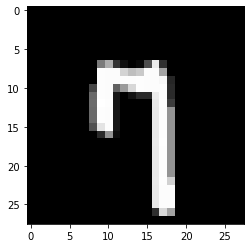

In [ ]:
test_point = (test_dataset.data[80].float(), test_dataset.targets[80])
plt.imshow(test_dataset.data[80], cmap = "gray")

Text(0.5, 1.0, '7')

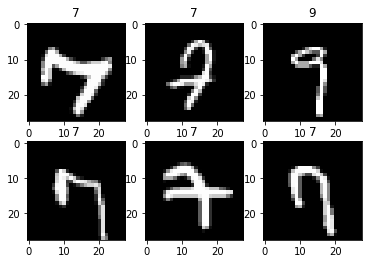

In [ ]:
fig, axs = plt.subplots(2, 3)
axs[0][0].imshow(train_dataset.data[if_score_series_sorted.index[0]], cmap = "gray")
axs[0][1].imshow(train_dataset.data[if_score_series_sorted.index[1]], cmap = "gray")
axs[0][2].imshow(train_dataset.data[if_score_series_sorted.index[2]], cmap = "gray")
axs[1][0].imshow(train_dataset.data[if_score_series_sorted.index[-1]], cmap = "gray")
axs[1][1].imshow(train_dataset.data[if_score_series_sorted.index[-2]], cmap = "gray")
axs[1][2].imshow(train_dataset.data[if_score_series_sorted.index[-3]], cmap = "gray")
#alpha_train_dataset[if_score_series_sorted.index[-1]][0]

axs[0, 0].set_title(str(train_dataset.targets[if_score_series_sorted.index[0]].item()))
axs[0, 1].set_title(str(train_dataset.targets[if_score_series_sorted.index[1]].item()))
axs[0, 2].set_title(str(train_dataset.targets[if_score_series_sorted.index[2]].item()))
axs[1, 0].set_title(str(train_dataset.targets[if_score_series_sorted.index[-1]].item()))
axs[1, 1].set_title(str(train_dataset.targets[if_score_series_sorted.index[-2]].item()))
axs[1, 2].set_title(str(train_dataset.targets[if_score_series_sorted.index[-3]].item()))

## Compare with leave one out training

In [ ]:
idx_to_remove = np.array(if_score_series_sorted.apply(lambda x: abs(x)).sort_values(ascending = False).index[:50])

In [ ]:
diff_in_loss_by_if = np.array(if_score_series[idx_to_remove]/(-training_size))

### Define dataset and find original test loss

In [ ]:
class One_Out_Train_Dataset(Dataset):
  def __init__(self, training_selector):
      
      self.x = train_dataset.data[training_selector].float()
      self.y = train_dataset.targets[training_selector]
      
      #self.n_samples = int(train_dataset.data.shape[0]*alpha)
      self.n_samples = len(training_selector)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

class Alpha_Test_Dataset(Dataset):
  def __init__(self):
      
      self.x = test_dataset.data[testing_selector].float()#[random_selector].float()
      self.y = test_dataset.targets[testing_selector]#[random_selector]
      
      self.n_samples = len(testing_selector)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

In [ ]:
test_point = (test_dataset.data[80].float(), test_dataset.targets[80])
test_image = ((test_point[0].reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)
test_label = torch.tensor([test_point[1]]).to(device)

In [ ]:
def loss_at_point(w, train_point):
    # w should be torch.cat(tuple([_.view(-1) for _ in model.parameters()]))
    # train_point should be alpha_train_dataset[0], a tuple of image and label

    images = ((train_point[0].reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)

    out1 = F.linear(images, w.reshape(10,784))

    loss = criterion(out1, torch.tensor([train_point[1]]).to(device))

    l2_lambda = 0.005
    l2_norm = sum(w.pow(2.0))
 
    loss = loss + l2_lambda * l2_norm

    return loss

In [ ]:
original_test_loss = loss_at_point(w, test_point).item()

### Calculate loss without one training point

In [ ]:
change_in_loss_lst = []
counter = 0
for idx in idx_to_remove:
    training_selector = np.concatenate((np.arange(0,idx), np.arange(idx+1,training_size)))

    alpha_train_dataset = One_Out_Train_Dataset(training_selector)

    train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=batch_size, shuffle=True)

    model = NeuralNet(input_size, num_classes).to(device) # use pretrained model instead
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # 100, 1, 28, 28
            images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)
            labels = labels.to(device)

            # forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            l2_lambda = 0.005
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
 
            loss = loss + l2_lambda * l2_norm

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    with torch.no_grad():
        test_output = model(test_image)
        test_loss = criterion(test_output, test_label)
        change_in_loss_lst.append(test_loss.item() - original_test_loss)
        counter = counter + 1
        print(f"{counter}/50 complete")

1/50 complete
2/50 complete
3/50 complete
4/50 complete
5/50 complete
6/50 complete
7/50 complete
8/50 complete
9/50 complete
10/50 complete
11/50 complete
12/50 complete
13/50 complete
14/50 complete
15/50 complete
16/50 complete
17/50 complete
18/50 complete
19/50 complete
20/50 complete
21/50 complete
22/50 complete
23/50 complete
24/50 complete
25/50 complete
26/50 complete
27/50 complete
28/50 complete
29/50 complete
30/50 complete
31/50 complete
32/50 complete
33/50 complete
34/50 complete
35/50 complete
36/50 complete
37/50 complete
38/50 complete
39/50 complete
40/50 complete
41/50 complete
42/50 complete
43/50 complete
44/50 complete
45/50 complete
46/50 complete
47/50 complete
48/50 complete
49/50 complete
50/50 complete


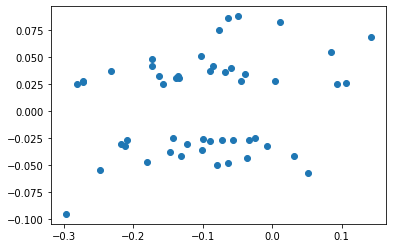

In [ ]:
change_in_loss_array = np.array(change_in_loss_lst)
scatter(change_in_loss_array, diff_in_loss_by_if)

## Sklearn Logistic Regression

In [ ]:
from sklearn import linear_model, preprocessing, cluster

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd.functional import hessian
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download = True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download = True)

In [ ]:
X_train = (train_dataset.data.reshape(-1, 784).numpy()/255 - 0.1307)/0.3081
Y_train = train_dataset.targets.numpy()

In [ ]:
X_test = (test_dataset.data.reshape(-1, 784).numpy()/255 - 0.1307)/0.3081
Y_test = test_dataset.targets.numpy()

In [ ]:
weight_decay = 0.01
batch_size = 1400
initial_learning_rate = 0.001 
keep_probs = None
max_lbfgs_iter = 3000
decay_epochs = [1000, 10000]
num_classes = 10
input_dim = 784

num_train_examples = len(Y_train)
assert len(Y_train.shape) == 1
assert X_train.shape[0] == Y_train.shape[0]

C = 1.0 / (num_train_examples * weight_decay) 

sklearn_model = linear_model.LogisticRegression(
            C=C,
            tol=1e-8,
            fit_intercept=False, 
            solver='lbfgs',
            multi_class='multinomial',
            warm_start=True, #True
            max_iter=max_lbfgs_iter)

In [ ]:
# print(X_train)
# print(Y_train)
sklearn_model.fit(X_train, Y_train)
# sklearn returns coefficients in shape num_classes x num_features
# whereas our weights are defined as num_features x num_classes
# so we have to tranpose them first.
W = np.reshape(sklearn_model.coef_.T, -1)

In [ ]:
Y_pred = sklearn_model.predict(X_test)

In [ ]:
(Y_pred == Y_test).mean()

0.9201

In [ ]:
w = torch.tensor(W).to(device)

In [ ]:
training_selector = np.arange(60000)
training_size = 60000
criterion = nn.CrossEntropyLoss()

class Alpha_Train_Dataset(Dataset):
  def __init__(self):
      
      self.x = train_dataset.data[training_selector].float()
      self.y = train_dataset.targets[training_selector]
      
      #self.n_samples = int(train_dataset.data.shape[0]*alpha)
      self.n_samples = len(training_selector)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

alpha_train_dataset = Alpha_Train_Dataset()

def logistics_regression_loss_all(w):
    
    #w = w.clone().detach().requires_grad_(True)

    train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=training_size, shuffle=False)
    examples = iter(train_loader)
    images, labels = examples.next()

    images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)

    out1 = F.linear(images, w.float().reshape(10,784))

    loss = criterion(out1, labels.to(device))*training_size

    return loss

In [ ]:
with torch.no_grad():
   Hessian = hessian(logistics_regression_loss_all, w)/training_size

In [ ]:
Hessian

tensor([[ 0.0134,  0.0134,  0.0134,  ..., -0.0013, -0.0013, -0.0013],
        [ 0.0134,  0.0134,  0.0134,  ..., -0.0013, -0.0013, -0.0013],
        [ 0.0134,  0.0134,  0.0134,  ..., -0.0013, -0.0013, -0.0013],
        ...,
        [-0.0013, -0.0013, -0.0013,  ...,  0.0139,  0.0139,  0.0139],
        [-0.0013, -0.0013, -0.0013,  ...,  0.0139,  0.0139,  0.0139],
        [-0.0013, -0.0013, -0.0013,  ...,  0.0139,  0.0139,  0.0139]],
       device='cuda:0', dtype=torch.float64)

In [ ]:
inv_hessian = torch.linalg.inv(Hessian)

_LinAlgError: ignored

In [ ]:
(Hessian == 0).sum()

tensor(0, device='cuda:0')